In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import pprint
import sys
import pathlib
parent_path = pathlib.Path.cwd().parent
sys.path.append(str(parent_path))
import socket
import time

from simpleByteProtocol import simpleRecv, simpleSend
from util import MESSAGE_TYPE, pprintResult, loadJsonResult
import krr
import oue
import olh

In [3]:
sns.set()
sns.set(font="serif")

## DecideSharedParameters

- 大体カテゴリ数の50倍~100倍くらいあれば近似精度は十分そう
- イプシロンが小さいと近似精度が低い傾向

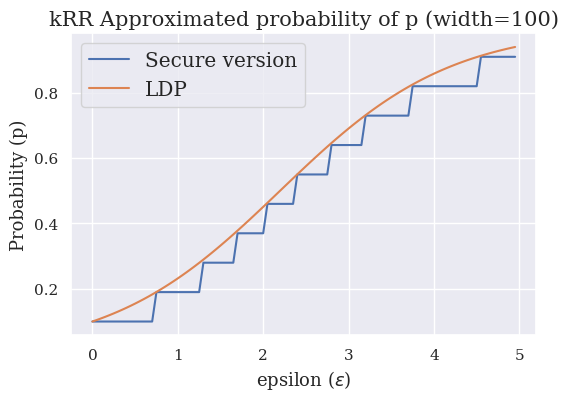

In [17]:
epsilon = 5
width = 100
cate_num = 10
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': [], 'protocol': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n, z = krr.buildKrrParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    data['protocol'].append('Secure version')
    ratio = np.exp(eps) / ((d-1) + np.exp(eps))
    data['epsilon'].append(eps)
    data['probability'].append(ratio)
    data['protocol'].append('LDP')

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", hue='protocol', data=data, ax=ax1)
ax1.set_title('kRR Approximated probability of p (width=%d)'% width, fontsize=15)
ax1.set_xlabel('epsilon ($\epsilon$)', fontsize=13)
ax1.set_ylabel('Probability (p)', fontsize=13)
ax1.legend(fontsize='large')
plt.show()
fig.savefig('dsp-width100-cate10.png')

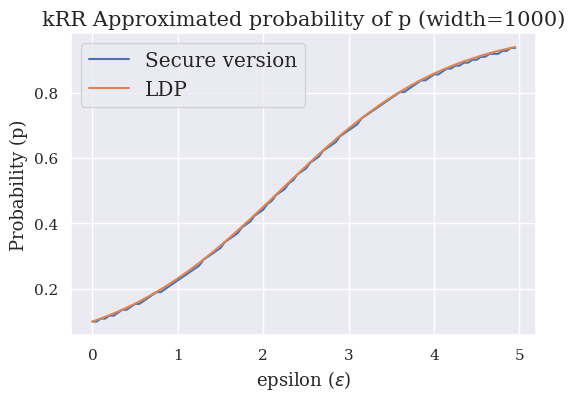

In [16]:
epsilon = 5
width = 1000
cate_num = 10
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': [], 'protocol': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n, z = krr.buildKrrParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    data['protocol'].append('Secure version')
    ratio = np.exp(eps) / ((d-1) + np.exp(eps))
    data['epsilon'].append(eps)
    data['probability'].append(ratio)
    data['protocol'].append('LDP')

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", hue='protocol', data=data, ax=ax1)
ax1.set_title('kRR Approximated probability of p (width=%d)'% width, fontsize=15)
ax1.set_xlabel('epsilon ($\epsilon$)', fontsize=13)
ax1.set_ylabel('Probability (p)', fontsize=13)
ax1.legend(fontsize='large')
plt.show()
fig.savefig('dsp-width1000-cate10.png')

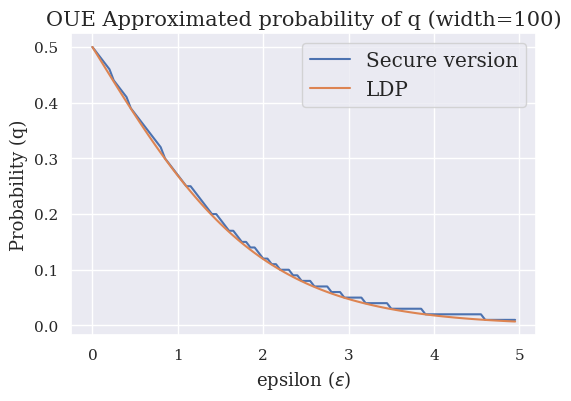

In [15]:
epsilon = 5
width = 100
cate_num = 10
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': [], 'protocol': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n = oue.buildOueParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    data['protocol'].append('Secure version')
    ratio = 1 / (np.exp(eps) + 1)
    data['epsilon'].append(eps)
    data['probability'].append(ratio)
    data['protocol'].append('LDP')

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", hue='protocol', data=data, ax=ax1)
ax1.set_title('OUE Approximated probability of q (width=%d)'% width, fontsize=15)
ax1.set_xlabel('epsilon ($\epsilon$)', fontsize=13)
ax1.set_ylabel('Probability (q)', fontsize=13)
ax1.legend(fontsize='large')
plt.show()
fig.savefig('oue-width100-cate-10.png')

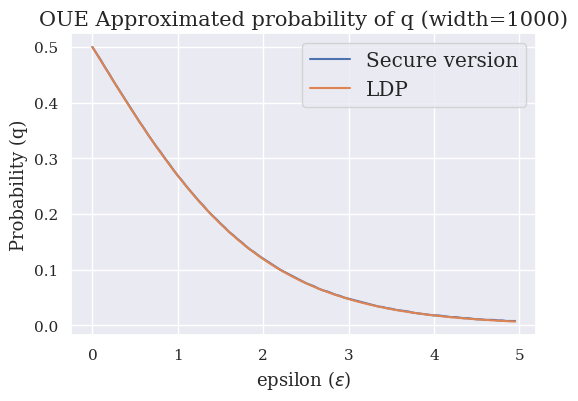

In [18]:
epsilon = 5
width = 1000
cate_num = 10
categories = list(range(0, cate_num))

data = {'epsilon': [], 'probability': [], 'protocol': []}

for i in range(0, 100):
    eps = epsilon * i / 100
    d, l, n = oue.buildOueParams(eps, width, categories)
    data['epsilon'].append(eps)
    data['probability'].append(l/n)
    data['protocol'].append('Secure version')
    ratio = 1 / (np.exp(eps) + 1)
    data['epsilon'].append(eps)
    data['probability'].append(ratio)
    data['protocol'].append('LDP')

fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(1, 1, 1) 

sns.lineplot(x="epsilon", y="probability", hue='protocol', data=data, ax=ax1)
ax1.set_title('OUE Approximated probability of q (width=%d)'% width, fontsize=15)
ax1.set_xlabel('epsilon ($\epsilon$)', fontsize=13)
ax1.set_ylabel('Probability (q)', fontsize=13)
ax1.legend(fontsize='large')
plt.show()
fig.savefig('oue-width100-cate-10.png')

## Methods KRR, OUE, OLH

- bandwidthは受け取る側のbandwidth

In [19]:
def grouping(results):
    grouped_results = {key: [] for key in results[0].keys()}
    for result in results:
        for k,v in result.items():
            grouped_results[k].append(v)
    calculateTotalBandwitdh(grouped_results)
    return grouped_results

def calculateTotalBandwitdh(grouped_results):
    grouped_results['total_bandwidth'] = []
    if grouped_results.get('MESSAGE_TYPE.START size [B]'):  
        for a, b, c in zip(
            grouped_results['MESSAGE_TYPE.START size [B]'],
            grouped_results['MESSAGE_TYPE.STEP2 size [B]'],
            grouped_results['MESSAGE_TYPE.STEP4 size [B]']
        ):
            grouped_results['total_bandwidth'].append(a+b+c)
    else:
        for a, b in zip(
            grouped_results['MESSAGE_TYPE.STEP1 size [B]'],
            grouped_results['MESSAGE_TYPE.STEP3 size [B]']
        ):
            grouped_results['total_bandwidth'].append(a+b)


def mean(grouped_results):
    mean_results = {}
    for k, v in grouped_results.items():
        mean_results[k] = np.mean(v)
    return mean_results

def std(grouped_results):
    mean_results = {}
    for k, v in grouped_results.items():
        mean_results[k] = np.std(v)
    return mean_results

def capitalize(mech):
    if mech == 'krr':
        return 'kRR'
    elif mech == 'oue':
        return 'OUE'
    elif mech == 'olh':
        return 'OLH'

In [31]:
a = [0, 1, 2]
list(filter(lambda x: x!=2, a))

[0, 1]

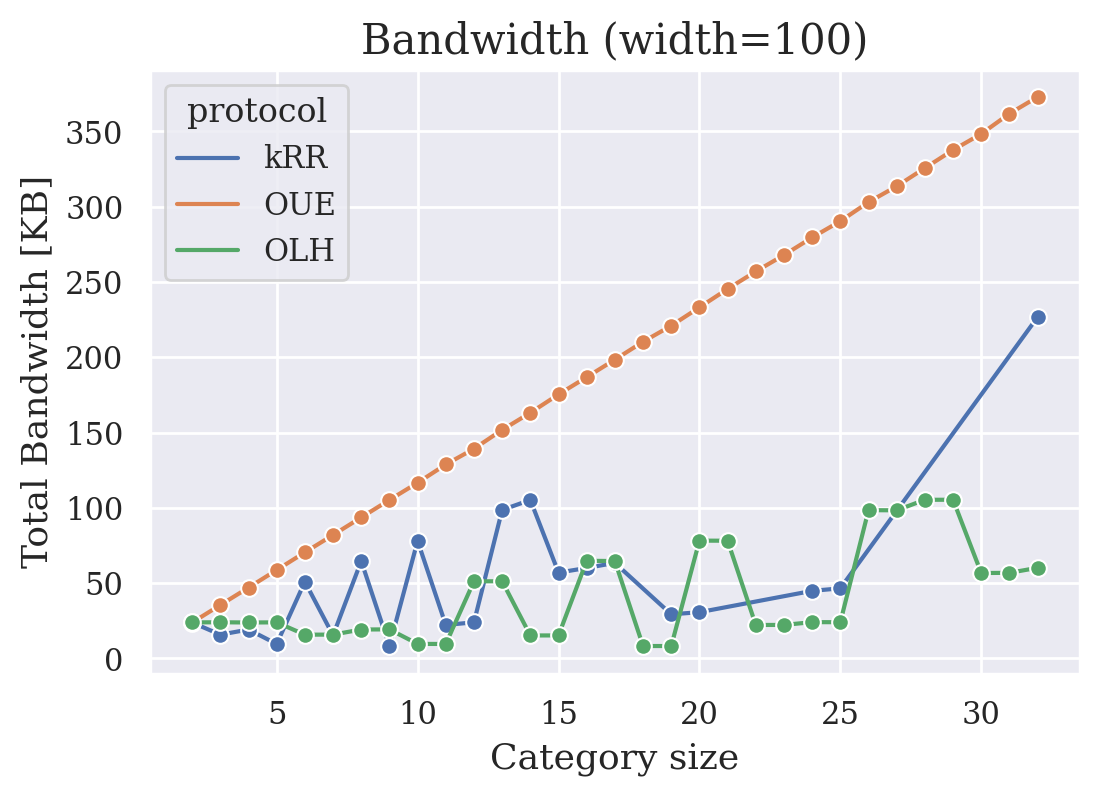

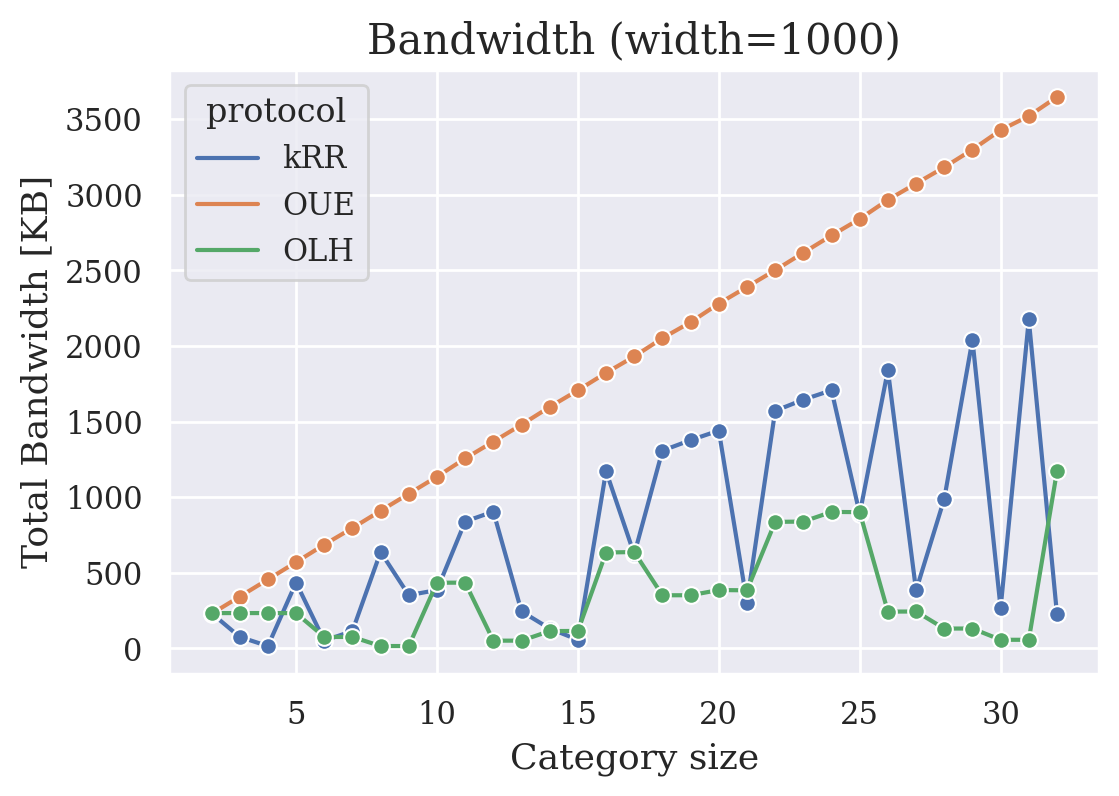

In [78]:
cate_num_list = list(range(2, 33))
role_list = ['verifier', 'prover']
epsilon = 1.0
secret_input = 1
width_list = [100, 1000]
mech_list = ['krr', 'oue', 'olh']

for width in width_list:
    data_bandwidth = {
        'cate_num': [],
        'bandwidth': [],
        'protocol': [],
    }
    for mech in mech_list:
        for cate_num in cate_num_list:
            bandwidth = 0
            is_exists = True
            for role in role_list:
                if mech == 'olh':
                    if cate_num <= 3:
                        g = 2
                    else:
                        g = cate_num // 2
                    if role == 'prover':
                        params = [role, cate_num, epsilon, secret_input, width, g, mech]
                    else:
                        params = [role, cate_num, epsilon, width, g, mech]
                elif role == 'prover':
                    params = [role, cate_num, epsilon, secret_input, width, mech]
                else:
                    params = [role, cate_num, epsilon, width, mech]
                results = loadJsonResult('../result', params)
                if len(results) == 0:
                    is_exists = False
                else:
                    grouped_results = grouping(results)
                    bandwidth += np.mean(grouped_results['total_bandwidth'])
            if is_exists:
                data_bandwidth['bandwidth'].append(bandwidth / 1000)
                data_bandwidth['cate_num'].append(cate_num)
                data_bandwidth['protocol'].append(capitalize(mech))
    fig = plt.figure(dpi=200)
    ax1 = fig.add_subplot(1, 1, 1) 
    sns.lineplot(x="cate_num", y="bandwidth", hue='protocol', data=data_bandwidth, ax=ax1, marker="o")
    ax1.set_title('Bandwidth (width=%d)'% (width), fontsize=15)
    ax1.set_xlabel('Category size', fontsize=13)
    ax1.set_ylabel('Total Bandwidth [KB]', fontsize=13)
    plt.show()
    fig.savefig('bandwidth-width-%d.png' % width)

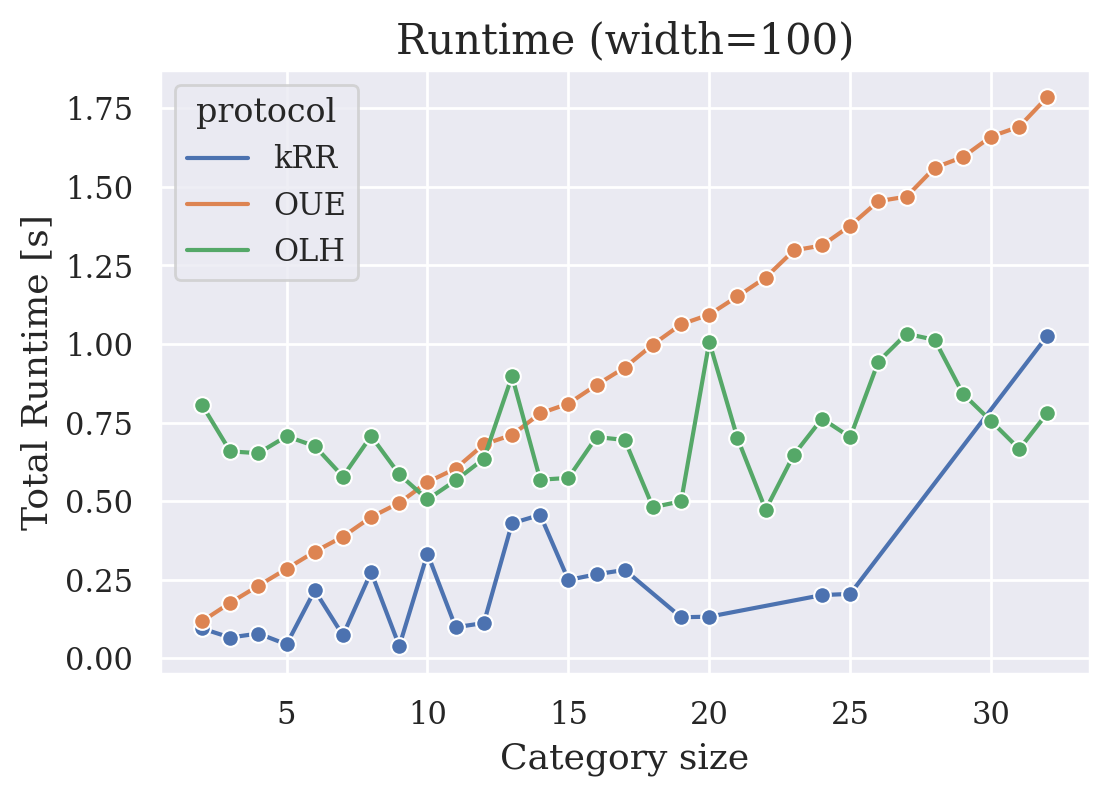

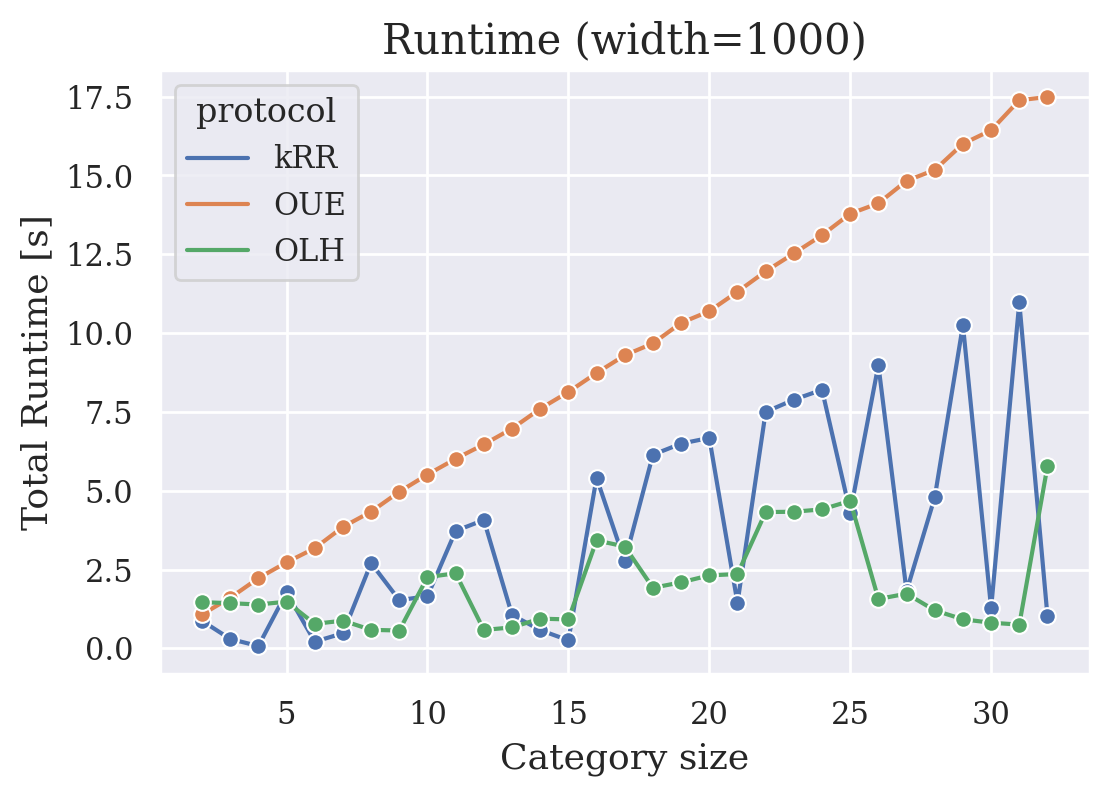

In [79]:
cate_num_list = list(range(2, 33))
role_list = ['verifier', 'prover']
epsilon = 1.0
secret_input = 1
width_list = [100, 1000]
mech_list = ['krr', 'oue', 'olh']

for width in width_list:
    data_bandwidth = {
        'cate_num': [],
        'runtime': [],
        'protocol': [],
    }
    for mech in mech_list:
        for cate_num in cate_num_list:
            is_exists = True
            if mech == 'olh':
                if cate_num <= 3:
                    g = 2
                else:
                    g = cate_num // 2
                params = ['prover', cate_num, epsilon, secret_input, width, g, mech]
            else:
                params = ['prover', cate_num, epsilon, secret_input, width, mech]

            results = loadJsonResult('../result', params)
            if len(results) == 0:
                is_exists = False
            else:
                grouped_results = grouping(results)
            if is_exists:
                data_bandwidth['runtime'].append(np.mean(grouped_results['overall time']))
                data_bandwidth['cate_num'].append(cate_num)
                data_bandwidth['protocol'].append(capitalize(mech))
    fig = plt.figure(dpi=200)
    ax1 = fig.add_subplot(1, 1, 1) 
    sns.lineplot(x="cate_num", y="runtime", hue='protocol', data=data_bandwidth, ax=ax1, marker="o")
    ax1.set_title('Runtime (width=%d)'% (width), fontsize=15)
    ax1.set_xlabel('Category size', fontsize=13)
    ax1.set_ylabel('Total Runtime [s]', fontsize=13)
    plt.show()
    fig.savefig('runtime-width-%d.png' % width)